# Starter Code

Use the following code as a guide for the case study.

## Helpful libraries to import

In [1]:
import os
import numpy as np
import ssl
from PIL import Image
import tensorflow as tf
import random
import shutil

# for unzipping the dataset:
import zipfile

# for data augmentation:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# possible pretrained models that can be imported:
from tensorflow.keras.applications import ResNet50V2, VGG19

# for optimizing the model:
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Sequential, load_model

# for creating visualizations:
import matplotlib.pyplot as plt

## Unzipping the data

In [2]:
with zipfile.ZipFile('brain_tumor_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('brain_tumor_dataset')

## Example code for train-test split

In [3]:
# create train and test folders
os.makedirs('train_dir', exist_ok = True)
os.makedirs('test_dir', exist_ok = True)

# create sub directories within the train and test folders for the yes and no tumor images
# First iterate through the "no" directory and then the "yes" directory
for subdir in os.listdir('brain_tumor_dataset/brain_tumor_dataset'):
    subdir_path = os.path.join('brain_tumor_dataset/brain_tumor_dataset', subdir)
    train_subdir = os.path.join('train_dir', subdir)
    test_subdir = os.path.join('test_dir', subdir)
    os.makedirs(train_subdir, exist_ok = True)
    os.makedirs(test_subdir, exist_ok = True)

    images = []

    # add all yes/no images to a list
    for image in os.listdir(subdir_path):
        images.append(image)

    # shuffle the images so they get randomly assigned to train or test
    random.shuffle(images)

    # split the images into train/test (20%/80%)
    test_count = int(len(images) * .2)

    # add the images to the correct train/test folder
    for i, image in enumerate(images):
        source_path = os.path.join(subdir_path, image) # get the original image path
        if i < test_count: # get first 20% of images and add them to the test directory
            dest_path = os.path.join(test_subdir, image)
        else: # add the remaining 80% of images to the train directory
            dest_path = os.path.join(train_subdir, image)
        shutil.copy(source_path, dest_path)

## Example code for data augmentation

In [4]:
# Augment the training set - you can adjust these parameters however you would like
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,  # Normalize pixel values
    rotation_range = 30,  # Randomly rotate images
    width_shift_range = 0.1,  # Randomly shift images horizontally
    height_shift_range = 0.1,  # Randomly shift images vertically
    shear_range = 0.1,  # Apply random shear transformations
    zoom_range = 0.1,  # Randomly zoom images
    horizontal_flip = True,  # Randomly flip images horizontally
    brightness_range = (.5, 1.0), # Randomly adjust brightness
    fill_mode = 'nearest'  # Fill in newly created pixels after transformations
)

# Don't augment the test set, just normalize pixel values
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255.
)

# loads and preprocesses the training data
train_gen = train_datagen.flow_from_directory(
    'train_dir', # path where the training images are stored
    target_size = (244, 244), # resizes the images to 244x244 pixels
    batch_size = 10, # number of images to include in each batch
    class_mode = 'binary', # labes are either 0 or 1
    color_mode = 'rgb' # image format is rgb
)

# loads and preprocesses the testing data
test_gen = test_datagen.flow_from_directory(
    'test_dir',
    target_size = (244, 244),
    batch_size = 10,
    class_mode = 'binary',
    color_mode = 'rgb'
)

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


## Example for building a model
This is example code for building a ResNet50 model. You can use this as a guide for implementing other architectures. Edit the hyperparameters and callbacks to increase accuracy.

In [6]:
# load the pretrained ResNet50 model
resnet_model = ResNet50V2(input_shape=(244,244,3), include_top=False) # setting include top = false allows us to add custom layers
resnet_model.trainable = False # freeze the weights of the pre-trained model so that only the custom layers will be updated

# add custom layers - this can be edited however you would like in order to increase accuracy
model = Sequential([
    resnet_model, # base model
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(256, activation="relu", kernel_initializer='he_normal'),
    Dropout(0.3), # helps prevent overfitting
    Dense(1, activation='sigmoid') # the 'sigmoid' activation is suitable for binary classification (what we are using)
])

# compile the model, tracking the accuracy during training
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=['accuracy'])

# save the best model during training
checkpoint = tf.keras.callbacks.ModelCheckpoint('resnet50v2_best.keras', monitor='accuracy', verbose=1, mode='max',save_best_only=True)

# creates a callback that stops training early if the accuracy does not improve for 5 epochs
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max", restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

# fit the model - you can change the number of epochs to increase accuracy
history_resnet = model.fit(train_gen, validation_data=test_gen, epochs=10, callbacks=callbacks_list)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6919 - loss: 0.6823
Epoch 1: accuracy improved from -inf to 0.74384, saving model to resnet50v2_best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.6942 - loss: 0.6780 - val_accuracy: 0.9000 - val_loss: 0.2837
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8504 - loss: 0.3502
Epoch 2: accuracy improved from 0.74384 to 0.88177, saving model to resnet50v2_best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8518 - loss: 0.3471 - val_accuracy: 0.8800 - val_loss: 0.2858
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8236 - loss: 0.3887
Epoch 3: accuracy did not improve from 0.88177
21/21 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8246 - loss: 0.3870 - val_accuracy: 0.9600 - val_loss: 0.2105
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9204 - loss: 0.2539
Epoch 4: accuracy improved from 0.88177 to 0.90640, saving model to resnet50v2_best.keras
21/21 ━━━━━━━━━━━━━━

## Example for creating visualizations
This example code can be used to plot the accuracy and loss of the training and validation sets over multiple epochs.

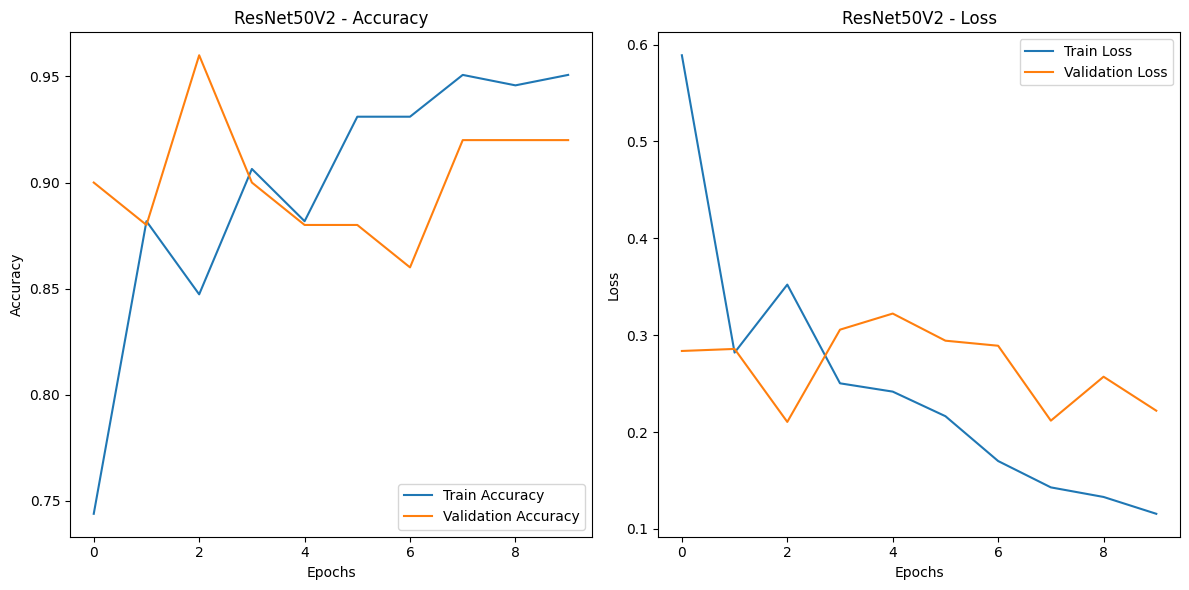

In [7]:
def plot_history(history, title):
    # Retrieve training history
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the history
plot_history(history_resnet, title="ResNet50V2")